<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S5/EVA4_S5_Solution_F4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code 4

### Target
*   Add dropout to handle overfitting

### Result
*   Parameters: 8,500
*   Best Train Accuracy: 99.32%
*   Best Test Accuracy: 99.46%

### Analysis
*   No overfitting at all
*   Not seeing 99.4% as often as we want to
*   The test accuracy keeps fluctuating possibly because of a high learning rate after few epochs

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
batch_size_cuda = 32
batch_size_cpu = 32

dataloader_args = dict(shuffle=True, batch_size=batch_size_cuda, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_cpu)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([32, 1, 28, 28])
torch.Size([32])


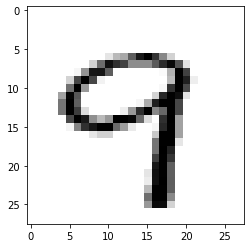

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

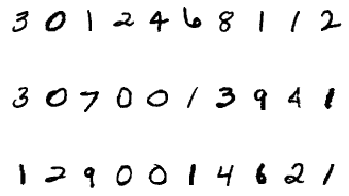

In [0]:
figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(3, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The Model


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05)
        ) # In: 28x28x1 | Out: 26x26x8 | RF: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)
        ) # In: 26x26x8 | Out: 24x24x10 | RF: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
        ) # In: 24x24x10 | Out: 22x22x12 | RF: 7

         # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # In: 22x22x12 | Out: 11x11x12 | RF: 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) # In: 11x11x12 | Out: 9x9x16 | RF: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) # In: 9x9x16 | Out: 7x7x16 | RF: 16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # In: 7x7x16 | Out: 5x5x16 | RF: 20

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1)
        ) # In: 5x5x16 | Out: 1x1x16 | RF: 28
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # In: 1x1x16 | Out: 1x1x10 | RF: 28


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,080
        MaxPool2d-10           [-1, 12, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,728
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
          Dropout-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.027382969856262207 Batch_id=1874 Accuracy=95.10: 100%|██████████| 1875/1875 [00:24<00:00, 78.02it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9849/10000 (98.49%)

EPOCH: 2


Loss=0.058527976274490356 Batch_id=1874 Accuracy=98.23: 100%|██████████| 1875/1875 [00:24<00:00, 77.58it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9862/10000 (98.62%)

EPOCH: 3


Loss=0.02741202712059021 Batch_id=1874 Accuracy=98.47: 100%|██████████| 1875/1875 [00:23<00:00, 79.94it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.029697075486183167 Batch_id=1874 Accuracy=98.67: 100%|██████████| 1875/1875 [00:23<00:00, 79.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.0416833758354187 Batch_id=1874 Accuracy=98.72: 100%|██████████| 1875/1875 [00:23<00:00, 78.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.010576412081718445 Batch_id=1874 Accuracy=98.88: 100%|██████████| 1875/1875 [00:23<00:00, 78.91it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.10878749191761017 Batch_id=1874 Accuracy=98.97: 100%|██████████| 1875/1875 [00:24<00:00, 77.13it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.0032797306776046753 Batch_id=1874 Accuracy=99.02: 100%|██████████| 1875/1875 [00:24<00:00, 77.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.0015516579151153564 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [00:24<00:00, 76.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.21422672271728516 Batch_id=1874 Accuracy=99.04: 100%|██████████| 1875/1875 [00:24<00:00, 77.94it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.004307478666305542 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [00:25<00:00, 74.63it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.01839539408683777 Batch_id=1874 Accuracy=99.13: 100%|██████████| 1875/1875 [00:24<00:00, 76.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.00442543625831604 Batch_id=1874 Accuracy=99.20: 100%|██████████| 1875/1875 [00:24<00:00, 76.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.13484928011894226 Batch_id=1874 Accuracy=99.25: 100%|██████████| 1875/1875 [00:24<00:00, 75.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.10671292990446091 Batch_id=1874 Accuracy=99.32: 100%|██████████| 1875/1875 [00:24<00:00, 75.83it/s]



Test set: Average loss: 0.0247, Accuracy: 9923/10000 (99.23%)



Text(0.5, 1.0, 'Test Accuracy')

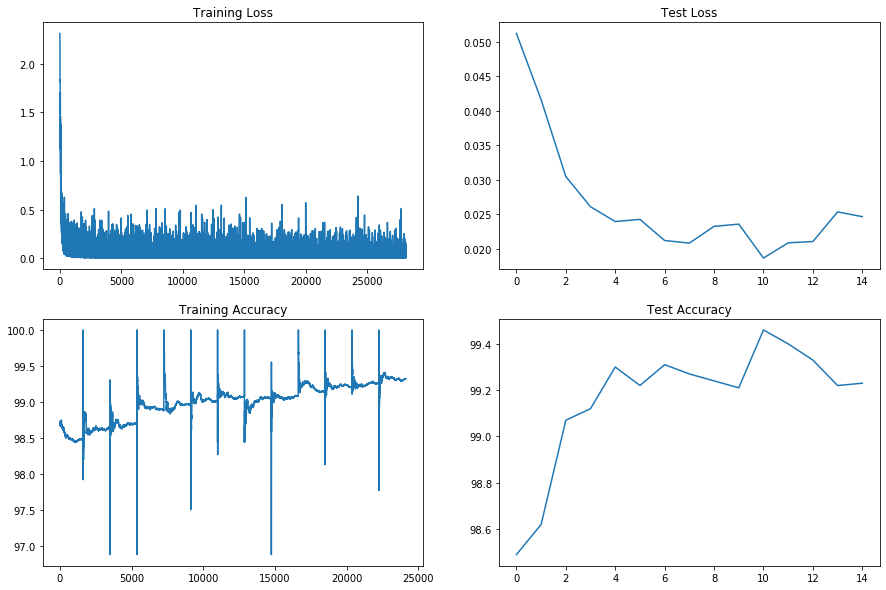

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")